# Raw

In [394]:
import requests
import re
import html
import json
from bs4 import BeautifulSoup
import pandas as pd

In [8]:
def getPostInfosFromContent(content):
    jsonDataArray = re.findall(r'\{\"result\"\:\{\"data.*?,\"variables', content)
    #ex. {"result": [get this result], "variables": [ignored]}
    posts = {}
    for jsonData in jsonDataArray:
        jsonData = jsonData[10: -31]
        try:
            data = json.loads(jsonData)['data']['feedback']
            commentsInfo = data['display_comments']['edges']
            comments = []
            for comment in commentsInfo:
                comment = comment['node']
                if comment['body'] is not None:
                    comments.append({
                        'id': comment['id'],
                        'time': comment['created_time'],
#                         'author': comment['author'], # deep information of user
                        'message': comment['body']['text'],
                        'like': comment['feedback']['reactors']['count']
                    })
            actorId = data['owning_profile']['id']
            postId = data['share_fbid']
            posts['{}_{}'.format(actorId, postId)] = {
                'like': data['reaction_count']['count'],
                'share': data['share_count']['count'],
                'comment': data['display_comments_count']['count'],
                'commentsHighlight': comments
            }
        except:
            continue
    return posts

In [9]:
def getPostsFromContent(content, postInfos):
    soup = BeautifulSoup(content, 'html.parser')
    divs = soup.find_all('div', {'class': '_5pcr userContentWrapper'})
    posts = []
    for div in divs:
        try:
            posts_id = div.find_all('div', {'class': '_5pcp _5lel _2jyu _232_'})
            posts_time = div.find_all('span', {'class': 'fsm fwn fcg'})
            posts_link = div.find_all('a', {'class': '_5pcq'})
            posts_text = div.find_all('div', {'class': '_5pbx userContent _3576'})
            postIds = [re.search(r'_[0-9]+;[0-9]+;', div['id']).group()[1:-1].replace(';', '_') for div in posts_id]
            postTimes = [int(span.abbr['data-utime']) for span in posts_time]
            postLinks = ['https://www.facebook.com' + a['href'] for a in posts_link]
            postMessages = []
            for div in posts_text:
                for span in div.find_all('span', {'class': 'text_exposed_hide'}):
                    span.decompose()
                for span in div.find_all('span', {'class': 'see_more_link_inner'}):
                    span.decompose()
                postMessages.append(div.get_text())
            posts.append({
                'id': postIds[0],
                'time': postTimes[0],
                'link': postLinks[0],
                'message': postMessages[0],
                'like': postInfos[postIds[0]]['like'],
                'share': postInfos[postIds[0]]['share'],
                'comment': postInfos[postIds[0]]['comment'],
                'commentsHighlight': postInfos[postIds[0]]['commentsHighlight']
            })
        except:
#             print('Exception')
            continue
    return posts

In [10]:
pageNameOrId = 'khaosod' #'MorningNewsTV3' #'thairath' #'khaosod' 
source_url = 'https://www.facebook.com/pg/%s/posts/' % pageNameOrId
content = html.unescape(requests.get(source_url).text)
postInfos = getPostInfosFromContent(content)
posts = getPostsFromContent(content, postInfos)
urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
# print(len(posts), posts[-1])
urlResult

'/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRulO8K-JNrfe80CH86ocODRGjYm_hEryIfGnGWbQOJXgsj58wTfE8lKQ9n-Uy57We7Gf1gmECPWQuOGP8r9YWPGi0M5wkMtb9vXhfiAsPy_EmObMdjrlLmP5a6ujEpTqQ%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8'

In [9]:
import datetime 
import time
now = datetime.datetime.now()
firstofjuly = now.replace(month=7,day=1,hour=0, minute=0, second=0, microsecond=0)
print(firstofjuly)
firstofjuly=int(time.mktime(firstofjuly.timetuple()))
print(firstofjuly)

testdate = now.replace(month=9,day=17,hour=0, minute=0, second=0, microsecond=0)
print(int(time.mktime(testdate.timetuple())))

2019-07-01 00:00:00
1561914000
1568653200


In [ ]:
# for i in range(5):
  while True:
    try:
        next_url = 'https://www.facebook.com%s&__a=1' % urlResult
        tmp_content = requests.get(next_url).text[9:]
        next_content = json.loads(tmp_content)
        content = html.unescape(next_content['domops'][0][3]['__html'])
        postInfos = getPostInfosFromContent(tmp_content)
        next_posts = getPostsFromContent(content, postInfos)
        filtered_post = [next_post for next_post in next_posts if next_post['time'] > firstofjuly]
        out_post = [next_post for next_post in next_posts if next_post['time'] <= firstofjuly]
        posts += filtered_post
        if len(filtered_post) < len(next_posts):
            print('End by date')
            break
        try:
            urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
        except:
            print('end')
            break
    except:
        print(next_url)
        continue
print(len(posts), posts[-1])

In [ ]:
# for i in range(5):
while True:
    try:
        next_url = 'https://www.facebook.com%s&__a=1' % urlResult
        tmp_content = requests.get(next_url).text[9:]
        next_content = json.loads(tmp_content)
        content = html.unescape(next_content['domops'][0][3]['__html'])
        postInfos = getPostInfosFromContent(tmp_content)
        next_posts = getPostsFromContent(content, postInfos)
        posts += next_posts
        try:
            urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
            print(urlResult)
        except:
            print('end')
            break
    except:
        print(next_url)
        continue
print(len(posts), posts[-1])

/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRwjQt8lPxNrlQgNdtk0GHOWNUe9T8Yv6ZpTYNBAHwHJdnAoViNhAZdkHsit6Tc5DMiGGkDfBw1o8LroUtm8ResfaHtW0cJmHEUAa_Nkvq1ZWlnUxEF-Ax-q2J6YPXLn5e%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRCQx_3q3WUpPHfq2I-lk2vzjYjZUkwpAiXK2c3sPH_fn17WEf6UiEKZhQlaWFOuSJ1T_Xk24Y7HYpoDwdBeAHSbwJ6LNCff9meznikz04gmNCJvsNbLdhOlQykCXCGSRf%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRZ5_hIEKtgeOk4rAq_Ng3xm9dh_rHezou6cD5edF8ZAUBPB1ICzyG2Z69_RxCAtAbdJrj8X1EV7RzaY9h1pY82RFG7szke4rz_MOjLmDPR-1w2pTSGujLiZHFX5LvFnDT%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_cou

/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRjN8ZUYhOsHrjkFlHNn77EtNFxPFQRVaFIzcyKxDP2v_sqvsYEEUgATGcyTd7ryAYq2ZAdYJ8lsD7lIWSsbw1XB4s-8f_EHzFdVDRxEulk9K7w-M78T0lM07BH9U5f_eR%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRyUY-wGEsiAHBWa17n4jzM4bPi_y8hdq3YzFXAbSkBlLX_0KKTwKcrO0oNn6tAubeDB3poXXjbCbbDM7TV2baZLvZv4z2Yi9mts6Qg_4T3qx1w9gHhKwZUQ-wRWc1VEdw%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRCpwK3r6Y6ugs5FAdwOctk7rnjLIStROuL1W38uCRHDbKG1-ynJus3uiWGS30v68IpDmPadBw4Cn0k1d_JThWwX9P85v23Ft709bjRJqxpHnvsM8uTKGPoVYbatP8SKW8%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_cou

/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHREjgvT_2xwFBCKSCtjZbDlRgCXzv6xM-ajsycusuZMfRk5KbtTSwZB744iJZ-jmzAqFBRnIBTIuxFELPVrDXlPlAn-YnH7Qw5OpFBIhbfFWBo6x1NwLE_lZUktrGZOZk7%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRZZIlK8uLxrQNdGb5UHviygv1uhiirW0uByp2deJuLVcY3AIy6belFrpCNi9o5DFaLe4Jwn8cpjOe3WNHd8N1ggNLVGPn1mXY399YZ3G8iH7FWYVs6yvFgPwHfS4GAr2Q%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHROhmELdmREKcjD2QbSU0vKUEfJBQO6oHNWJAgP2kheuunOehbN3OeDbYLBzAvZn5xPMZc_7P7Bs-suY68qFv_b3tO-flqPerH5BvLc1RzGWLHUbRu4Q4-HrZ-Qrp-BTD0%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_cou

/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRrqLMjtLO8zeci12fkYGBpJY-5MnRMA-A1hEoZfwvWUMe1pRQPQUAsixmoAL6iQw_2-sGlsyDno0Zz2hMycoiwCsLCmvZHW2zeMCqyrgNHkzkaPIPz6YQNH3wJA5zhVnR%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRQekthk4bWw9kNeFu7paoh7NFERXup_0B29fAKln5DrvkyGpCu5c6YKCoYuZRJifV-ZlfXMtTsZF_ClUovS5CAnMStRtYFq8WhV82SCJwitnkP4Kn0PLawY87XVGmrAe_%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRvKDQoGTGlU_WlxF7V3RP93akzrsCPOKa7UJRbwBc9s-b_nVy1hbRo3L18r5a04BxEokexENqdtmWHknwtjn977eF8KSqF9-oT1lGLlI5iSYn8bwf8MawAZcM8LdF7hB8%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_cou

https://www.facebook.com/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRSUROsQ5LzKW4TM67hQsmo0vKDGBaVNFIbINPG1KRQfT-F7xlA83lOlFty5Rap_ugB-FSZGqHf56LoUkYsC0J7oimnSZR1G-HXTc0Ai_L0oCrmywv34DEW6gqukZSFi4e%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8&__a=1
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRbY9XBPr9mJ5sy6SclYc6hsrOMkQWIu_yMATKws9oYPjajyi4op7Ftf_becJzRLT2_DbpbjCBdGPsnSXZTxkWL6o38LiR8Mlg9rm6wNJ-oaJL_UOWdP872Tn9iCNxVg4x%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8
/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRJmUMQXUWB6ibby2gGBEtIKA3skWntMeaWz_AT4KUacVZIHm6EqvMPmDztmq-BD60QyaxqVeCCOLvBJmpz_iUuMAvvB6-SYDQ38LDAL1ldMxaopyutD4FS8z9U6d1kpyh%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&su

In [3]:
content

NameError: name 'content' is not defined

# TEST

In [4]:
def getPostInfosFromContent(content):
    jsonDataArray = re.findall(r'\{\"result\"\:\{\"data.*?,\"variables', content)
    #ex. {"result": [get this result], "variables": [ignored]}
    posts = {}
    for jsonData in jsonDataArray:
        jsonData = jsonData[10: -31]
        try:
            data = json.loads(jsonData)['data']['feedback']
            commentsInfo = data['display_comments']['edges']
            comments = []
            for comment in commentsInfo:
                comment = comment['node']
                if comment['body'] is not None:
                    comments.append({
                        'id': comment['id'],
                        'time': comment['created_time'],
#                         'author': comment['author'], # deep information of user
                        'message': comment['body']['text'],
                        'like': comment['feedback']['reactors']['count']
                    })
            actorId = data['owning_profile']['id']
            postId = data['share_fbid']
            posts['{}_{}'.format(actorId, postId)] = {
                'like': data['reaction_count']['count'],
                'share': data['share_count']['count'],
                'comment': data['display_comments_count']['count'],
                'commentsHighlight': comments
            }
        except:
            continue
    return posts

def getPostsFromContent(content, postInfos):
    soup = BeautifulSoup(content, 'html.parser')
    divs = soup.find_all('div', {'class': '_5pcr userContentWrapper'})
    posts = []
    for div in divs:
        try:
            posts_id = div.find_all('div', {'class': '_5pcp _5lel _2jyu _232_'})
            posts_time = div.find_all('span', {'class': 'fsm fwn fcg'})
            posts_link = div.find_all('a', {'class': '_5pcq'})
            posts_text = div.find_all('div', {'class': '_5pbx userContent _3576'})
            postIds = [re.search(r'_[0-9]+;[0-9]+;', div['id']).group()[1:-1].replace(';', '_') for div in posts_id]
            postTimes = [int(span.abbr['data-utime']) for span in posts_time]
            postLinks = ['https://www.facebook.com' + a['href'] for a in posts_link]
            postMessages = []
            for div in posts_text:
                for span in div.find_all('span', {'class': 'text_exposed_hide'}):
                    span.decompose()
                for span in div.find_all('span', {'class': 'see_more_link_inner'}):
                    span.decompose()
                postMessages.append(div.get_text())
            posts.append({
                'id': postIds[0],
                'time': postTimes[0],
                'link': postLinks[0],
                'message': postMessages[0],
                'like': postInfos[postIds[0]]['like'],
                'share': postInfos[postIds[0]]['share'],
                'comment': postInfos[postIds[0]]['comment'],
                'commentsHighlight': postInfos[postIds[0]]['commentsHighlight']
            })
        except:
#             print('Exception')
            continue
    return posts

# Working

page_id(varchar)	
post_id(int)
post_user_id(int)
post_link(varchar)	
post_time(datetime)	
post_share_count(int)	
post_like_count(int)	
post_angry_count(int)	
post_love_count(int)	
post_sad_count(int)	
post_wow_count(int)	
post_haha_count(int)	
crawl_timestamp(datetime)

In [5]:
import datetime
def get_post_detail(content,content2):
    jsonDataArray = re.findall(r'\{\"result\"\:\{\"data.*?,\"variables', content)
#     print(len(jsonDataArray))#19
    posts_info = {}
    for jsonData in jsonDataArray: # some string
        # print(jsonData[0:10])#{"result":
        jsonData=jsonData[10: -31] # remove {"result":

        data= json.loads(jsonData)['data']['feedback']
        # print(data.keys())
        post_id =data['share_fbid']
        # print(post_id)
        post_user_id = data['owning_profile']['id']
        # print(post_user_id)
        post_link = data['url']
        # post_time(datetime)#########
        post_share_count =data['share_count']['count']
        post_reactor_count= data['reactors']['count']
        # print(len(data['top_reactions']['edges']))
        post_comment_count=data['comment_count']['total_count']
        post_react_dict ={'LIKE':0
                         ,'HAHA':0
                         ,'WOW':0
                         ,'SORRY':0
                         ,'LOVE':0
                         ,'ANGER':0}

        for edge in data['top_reactions']['edges']:
            post_react_dict[edge['node']['reaction_type']]=edge['reaction_count']

        post_like_count = post_react_dict['LIKE']
        post_angry_count = post_react_dict['ANGER']
        post_love_count = post_react_dict['LOVE']
        post_sad_count = post_react_dict['SORRY']
        post_wow_count = post_react_dict['WOW']
        post_haha_count = post_react_dict['HAHA']
        crawl_timestamp =datetime.datetime.now()

        posts_info['{}_{}'.format(post_user_id, post_id)] = {
            'post_id':post_id
            ,'post_user_id':post_user_id
            ,'post_link': post_link
            ,'post_share_count':post_share_count
            ,'post_reactor_count': post_reactor_count
            ,'post_comment_count': post_comment_count
            ,'post_like_count':post_like_count
            ,'post_angry_count':post_angry_count
            ,'post_love_count':post_love_count
            ,'post_sad_count':post_sad_count
            ,'post_wow_count':post_wow_count
            ,'post_haha_count':post_haha_count
            ,'crawl_timestamp':crawl_timestamp}
        
    soup = BeautifulSoup(content2, 'html.parser')
    divs = soup.find_all('div', {'class': '_5pcr userContentWrapper'})
    posts = []

    for div in divs:
        try:
            posts_id = div.find_all('div', {'class': '_5pcp _5lel _2jyu _232_'})
            posts_time = div.find_all('span', {'class': 'fsm fwn fcg'})
            posts_link = div.find_all('a', {'class': '_5pcq'})
            posts_text = div.find_all('div', {'class': '_5pbx userContent _3576'})
            postIds = [re.search(r'_[0-9]+;[0-9]+;', div['id']).group()[1:-1].replace(';', '_') for div in posts_id]
            postTimes = [int(span.abbr['data-utime']) for span in posts_time]
            postLinks = ['https://www.facebook.com' + a['href'] for a in posts_link]
            postMessages = []
            for div in posts_text:
                for span in div.find_all('span', {'class': 'text_exposed_hide'}):
                    span.decompose()
                for span in div.find_all('span', {'class': 'see_more_link_inner'}):
                    span.decompose()
                postMessages.append(div.get_text())
            posts.append({
                'post_page_id':posts_info[postIds[0]]['post_user_id'],
                'post_id': posts_info[postIds[0]]['post_id'],
                'post_time': postTimes[0],
                'post_link': postLinks[0],
                'post_message': postMessages[0],
                'post_like_count': posts_info[postIds[0]]['post_like_count'],
                'post_share_count': posts_info[postIds[0]]['post_share_count'],
                'post_reactor_count': posts_info[postIds[0]]['post_reactor_count'],
                'post_comment_count': posts_info[postIds[0]]['post_comment_count'],
                'post_angry_count':posts_info[postIds[0]]['post_angry_count'],
                'post_love_count':posts_info[postIds[0]]['post_love_count'],
                'post_sad_count':posts_info[postIds[0]]['post_sad_count'],
                'post_wow_count':posts_info[postIds[0]]['post_wow_count'],
                'post_haha_count':posts_info[postIds[0]]['post_haha_count'],
                'post_crawl_time':crawl_timestamp
            })
        except:
            continue
    return posts
# get_post_detail(content)

In [ ]:
jsonDataArray = re.findall(r'\{\"result\"\:\{\"data.*?,\"variables', content)
#     print(len(jsonDataArray))#19
posts_info = {}
for jsonData in jsonDataArray: # some string
    # print(jsonData[0:10])#{"result":
    jsonData=jsonData[10: -31] # remove {"result":

    data= json.loads(jsonData)['data']['feedback']
    # print(data.keys())
    post_id =data['share_fbid']
    # print(post_id)
    post_user_id = data['owning_profile']['id']
    # print(post_user_id)
    post_link = data['url']
    # post_time(datetime)#########
    post_share_count =data['share_count']['count']
    post_reactor_count= data['reactors']['count']
    # print(len(data['top_reactions']['edges']))
    post_comment_count=data['comment_count']['total_count']
    post_react_dict ={'LIKE':0
                     ,'HAHA':0
                     ,'WOW':0
                     ,'SORRY':0
                     ,'LOVE':0
                     ,'ANGER':0}

    for edge in data['top_reactions']['edges']:
        post_react_dict[edge['node']['reaction_type']]=edge['reaction_count']

    post_like_count = post_react_dict['LIKE']
    post_angry_count = post_react_dict['ANGER']
    post_love_count = post_react_dict['LOVE']
    post_sad_count = post_react_dict['SORRY']
    post_wow_count = post_react_dict['WOW']
    post_haha_count = post_react_dict['HAHA']
    crawl_timestamp =datetime.datetime.now()

    posts_info['{}_{}'.format(post_user_id, post_id)] = {
        'post_id':post_id
        ,'post_user_id':post_user_id
        ,'post_link': post_link
        ,'post_share_count':post_share_count
        ,'post_reactor_count': post_reactor_count
        ,'post_comment_count': post_comment_count
        ,'post_like_count':post_like_count
        ,'post_angry_count':post_angry_count
        ,'post_love_count':post_love_count
        ,'post_sad_count':post_sad_count
        ,'post_wow_count':post_wow_count
        ,'post_haha_count':post_haha_count
        ,'crawl_timestamp':crawl_timestamp}

In [16]:
next_url = 'https://www.facebook.com%s&__a=1' % urlResult
next_url

'https://www.facebook.com/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHRulO8K-JNrfe80CH86ocODRGjYm_hEryIfGnGWbQOJXgsj58wTfE8lKQ9n-Uy57We7Gf1gmECPWQuOGP8r9YWPGi0M5wkMtb9vXhfiAsPy_EmObMdjrlLmP5a6ujEpTqQ%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8&__a=1'

# RUN

In [ ]:
pageNameOrId = 'khaosod' #'MorningNewsTV3' #'thairath' #'khaosod' 
source_url = 'https://www.facebook.com/pg/%s/posts/' % pageNameOrId
content = html.unescape(requests.get(source_url).text)
# postInfos = getPostInfosFromContent(content)
# posts = getPostsFromContent(content, postInfos)
urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
# print(len(posts), posts[-1])
urlResult
posts=[]
# for i in range(10):
while True:
    try:
        next_url = 'https://www.facebook.com%s&__a=1' % urlResult
        tmp_content = requests.get(next_url).text[9:]
        next_content = json.loads(tmp_content)
        content = html.unescape(next_content['domops'][0][3]['__html'])
#         postInfos = getPostInfosFromContent(tmp_content)
#         next_posts = getPostsFromContent(content, postInfos)
        next_posts=get_post_detail(tmp_content,content)
#         print(next_posts[0])
        posts += next_posts
        try:
            urlResult = re.search(r'\/pages_reaction_units.*?unit_count=8', content).group()
        except:
            print('end')
            break
    except:
        print(next_url)
        continue
        
df = pd.DataFrame(posts)
df['page_name']=pageNameOrId
df['post_time']=pd.to_datetime(df['post_time'],unit='s')
df['post_crawl_time']=pd.to_datetime(df['post_crawl_time'])
df.to_csv(pageNameOrId.replace('.','_')+'.csv')
# from google.colab import files
# files.download(pageNameOrId.replace('.','_')+'.csv')
print(df.head(1))

https://www.facebook.com/pages_reaction_units/more/?page_id=129558990394402&cursor=%7B%22timeline_cursor%22%3A%22AQHREVRg3B98o3N6ESlHihpKvgQHK6DcX-da_HmBcTwr5Tyhl7__1hjGDd0xdvrDtsPdVGO_wLwBJ09D-P8JCg3TH67WSFS-ECmrBEYwf24SQtusiopWx8eIn7RJn5nlUmqK%22%2C%22timeline_section_cursor%22%3A%7B%7D%2C%22has_next_page%22%3Atrue%7D&surface=www_pages_posts&unit_count=8&__a=1


In [26]:
df = pd.DataFrame(posts)
df['page_name']=pageNameOrId
df['post_time']=pd.to_datetime(df['post_time'],unit='s')
df['post_crawl_time']=pd.to_datetime(df['post_crawl_time'])
df.to_csv(pageNameOrId.replace('.','_')+'.csv')
# from google.colab import files
# files.download(pageNameOrId.replace('.','_')+'.csv')
print(df.head(1))

,post_page_id,post_id,post_time,post_link,post_message,post_like_count,post_share_count,post_reactor_count,post_comment_count,post_angry_count,post_love_count,post_sad_count,post_wow_count,post_haha_count,post_crawl_time,pagename
0,129558990394402,4331032443580348,2019-11-12 15:21:31,https://www.facebook.com/khaosod/posts/4331032...,คนงานไทยในอิสราเอลต้องระวังตัวอีกแล้ว ผลกระทบอ...,209,11,233,7,1,1,16,5,1,2019-11-13 02:47:37.357244,khaosod
1,129558990394402,4331018070248452,2019-11-12 15:14:58,https://www.facebook.com/khaosod/posts/4331018...,จะหยุดขาดทุนแล้ว!,818,23,1296,216,4,4,2,40,428,2019-11-13 02:47:37.357244,khaosod
2,129558990394402,4330991473584445,2019-11-12 15:01:10,https://www.facebook.com/khaosod/posts/4330991...,พิลึกจริง! หนุ่มส่งของออกอุบายหลอกยาย ขโมยทอง ...,582,9,640,26,1,1,2,11,43,2019-11-13 02:47:37.357244,khaosod
3,129558990394402,4330912990258960,2019-11-12 14:55:10,https://www.facebook.com/khaosod/posts/4330912...,ตัวแทนลิขสิทธิ์ แจ้งจับเกรียนคีย์บอร์ด,786,16,1367,303,14,1,1,32,533,2019-11-13 02:47:37.357244,khaosod
4,129558990394402,4330938996923026,2019-11-12 14:35:57,https://www.facebook.com/khaosod/posts/4330938...,เก๋งพุ่งชนจักรยาน คนขี่กระเด็น ตัวปลิวทะลุกระจ...,676,14,846,25,1,0,147,21,1,2019-11-13 02:47:37.357244,khaosod


# Post interactions


In [388]:
import re, os, csv, sys, time
import json, random, argparse

from collections import Counter
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException


BASE_URL='https://mbasic.facebook.com/'
def pause(min=2,max=5):
    return round(random.uniform(min,max),1)
def parse_likers(html):
    return re.findall('<h3 class=".[^"]*"><a href="(.[^"]*)[^"]*">(.[^<]*)</a></h3>',html)

def get_all_reactions(driver,url,reactions_per_page=4000,limit=2000,cur_length=0):

    if cur_length >=limit: 
        return []

    driver.get(url)
    html = driver.page_source.encode("utf-8",errors='replace').decode("utf-8", errors="replace")

    reactions = parse_likers(html)
    cur_length += len(reactions)
    
    reaction_urls = re.findall('(/ufi/reaction/profile/browser/(?!.*(?:reaction_type|total_count=0)).[^"]*)',html)
    reaction_urls = ['%s%s'% (BASE_URL,x.replace('&amp;','&').replace('?limit=10','?limit=%d' % reactions_per_page)) for x in reaction_urls]
    if(reaction_urls) and limit > cur_length:
        print(cur_length)
        time.sleep(pause())
        url= reaction_urls[0]
        reactions += get_all_reactions(driver,url,reactions_per_page,limit,cur_length)
    return reactions

def do_login(driver,usr,pwd):

    print('[*] Trying to log in with user %s' % usr)
    driver.get('https://www.facebook.com')
    try:
        elem = driver.find_element_by_id('email')
        elem.send_keys(usr)
        elem = driver.find_element_by_id('pass')
        elem.send_keys(pwd)
    except NoSuchElementException:
        elem = driver.find_element_by_name('email')
        elem.send_keys(usr)
        elem = driver.find_element_by_name('pass')
        elem.send_keys(pwd)
    except Exception as ex:
        print('[!] Error while logging in:')
        print(ex)
        sys.exit(0)
    elem.send_keys(Keys.RETURN)
    time.sleep(pause(2,3))

In [259]:
import configparser

config = configparser.ConfigParser()
config.read('myconfig.ini')
usr=config['FB']['user']
pwd=config['FB']['pw']

In [389]:
from  selenium import webdriver
import datetime


def get_reaction_url(browser,post_link):
    browser.get(post_link)
    if post_link.find('/videos/')>0:
        get_element  = browser.find_elements_by_class_name("_7goz")
        soup = BeautifulSoup(get_element[0].get_attribute('innerHTML'), 'html.parser')
        return soup.find_all('a',{'class':'_7gm_'})[0]['href']
    else:
        get_element  = browser.find_elements_by_class_name("_66lg")
        soup = BeautifulSoup(get_element[0].get_attribute('innerHTML'), 'html.parser')
        return soup.find_all('a',{'class':'_3dlf'})[0]['href']

def get_react_usr_list(browser,post_url,reactions_per_page=4000):
    react_url ='https://mbasic.facebook.com'+get_reaction_url(browser,post_url)
    browser.get(react_url)
    get_element  = browser.find_elements_by_class_name("z")
    # print(len(get_element))
    soup = BeautifulSoup(get_element[0].get_attribute('innerHTML'), 'html.parser')
    # print(len(soup))
    reacts_list= soup.find_all('a',{'class':'ba'})
    reacts_usr_list=[]
    for react in reacts_list:
        react_type_url =react['href'].replace('?limit=10','?limit=%d' % reactions_per_page)
        if not(react.findChild() is None):
            react_name=react.findChild()['alt']
            tmp = get_all_reactions(browser,BASE_URL+react_type_url,reactions_per_page)
            reacts_usr_list+=[(post_url,str(react_type_url),react_name,a[0],a[1],datetime.datetime.now()) for a in tmp]
    return reacts_usr_list




In [349]:
driver_path = r'chromedriver.exe'
browser = webdriver.Chrome(executable_path=driver_path)

do_login(browser,usr,pwd)


#DO LOOP POST URL  BELOW

post_url = 'https://www.facebook.com/khaosod/posts/4333333783350214'

usr_list=get_react_usr_list(browser,post_url)

[*] Trying to log in with user poom_tanawat@hotmail.com
urls 0
urls 0
urls 0
urls 0


In [379]:
react_type_url

'/ufi/reaction/profile/browser/fetch/?limit=10&reaction_type=4&total_count=1&ft_ent_identifier=4333333783350214'

In [386]:
browser.get(BASE_URL+react_type_url)
reactions_per_page=9999
html = browser.page_source.encode("utf-8",errors='replace').decode("utf-8", errors="replace")
reaction_urls=re.findall('(/ufi/reaction/profile/browser/(?!.*(?:reaction_type=\d{}|total_count=\d{})).[^"]*)',html)
reaction_urls = ['%s%s'% (BASE_URL,x.replace('&amp;','&').replace('?limit=10','?limit=%d' % reactions_per_page)) for x in reaction_urls]
reaction_urls

['https://mbasic.facebook.com//ufi/reaction/profile/browser/fetch/?limit=9999&total_count=336&ft_ent_identifier=4333333783350214',
 'https://mbasic.facebook.com//ufi/reaction/profile/browser/fetch/?limit=9999&reaction_type=1&total_count=330&ft_ent_identifier=4333333783350214',
 'https://mbasic.facebook.com//ufi/reaction/profile/browser/fetch/?limit=9999&reaction_type=3&total_count=3&ft_ent_identifier=4333333783350214',
 'https://mbasic.facebook.com//ufi/reaction/profile/browser/fetch/?limit=9999&reaction_type=2&total_count=2&ft_ent_identifier=4333333783350214',
 'https://mbasic.facebook.com//ufi/reaction/profile/browser/fetch/?limit=9999&reaction_type=4&total_count=1&ft_ent_identifier=4333333783350214']

In [344]:
import pandas as pd
df=pd.DataFrame(usr_list,columns=['post_url','react_url','type','user_url','usr_name','crawl_timestamp'])
df.groupby(['post_url','type']).count()

react_url  user_url  \
post_url                                           type                        
https://www.facebook.com/khaosod/posts/43333337... Haha          1         1   
                                                   Like        329       329   
                                                   Love          2         2   
                                                   Wow           3         3   

                                                         usr_name  \
post_url                                           type             
https://www.facebook.com/khaosod/posts/43333337... Haha         1   
                                                   Like       329   
                                                   Love         2   
                                                   Wow          3   

                                                         crawl_timestamp  
post_url                                           type                   
https://www.facebook.com/khaosod/posts/43333337... Haha                1  
                                                   Like              329  
                                                   Love                2  
                                                   Wow                 3

In [413]:
#all post
link_list=df_post['post_link'].values

#check point
last_post ='https://www.facebook.com/khaosod/posts/4330387983644794'
last_post_index=df_post[df_post['post_link']==last_post].index[0]
link_list=df_post.loc[last_post_index:,['post_link']].values

In [ ]:
# Crawler
driver_path = r'chromedriver.exe'
browser = webdriver.Chrome(executable_path=driver_path)
do_login(browser,usr,pwd)
usr_list=[]
filename='khaosod'
df_post =pd.read_csv('crawl_data/{}.csv'.format(filename))

for i, link in enumerate(link_list):
    tmp=get_react_usr_list(browser,link)
    usr_list+=tmp
    print(i,'completed',len(tmp))

[*] Trying to log in with user poom_tanawat@hotmail.com


In [391]:
import pandas as pd
df=pd.DataFrame(usr_list,columns=['post_url','react_url','type','user_url','usr_name','crawl_timestamp'])
df.to_csv('{}_post_interact.csv'.format(filename))

In [393]:
df.groupby(['post_url','type']).count()
len(df)

234862

# Analysis


## page analysis

In [12]:

# varify the path using getcwd() 
cwd = os.getcwd() 
print(cwd)

C:\Users\Tanawat Chiewhawn\PycharmProjects\sna_project


In [13]:
import glob
import os
import pandas as pd

filelist = []

csv_path ='crawl_data/'
cwd = os.getcwd() 
os.chdir(csv_path)
for counter, files in enumerate(glob.glob("*.csv")):
    filelist.append(files)
    
os.chdir(cwd)

In [5]:
filelist

['DramaAdd.csv',
 'khaosod.csv',
 'MorningNewsTV3.csv',
 'thairath.csv',
 'workpoint.csv']

In [57]:
import pandas as pd
# filename='khaosod'

for i,filename in enumerate(filelist):
    if i == 0:
        df_post =pd.read_csv('crawl_data/{}'.format(filename))
        df_post['filename'] =filename
    else:
        tmp=pd.read_csv('crawl_data/{}'.format(filename))
        tmp['filename'] =filename
        df_post=df_post.append(tmp)
        
print(len(df_post))
df_post

12912


,Unnamed: 0,post_page_id,post_id,post_time,post_link,post_message,post_like_count,post_share_count,post_reactor_count,post_comment_count,post_angry_count,post_love_count,post_sad_count,post_wow_count,post_haha_count,post_crawl_time,page_name,filename
0,0,141108613290,10158025410753291,2019-11-13 05:50:32,https://www.facebook.com/DramaAdd/posts/101580...,ขอแสดงความยินดีกับครอบครัวของคนเจ็บด้วยค้าบบบบบบ,5973,166,6304,425,11,102,48,34,136,2019-11-13 18:23:24.509213,DramaAdd,DramaAdd.csv
1,1,141108613290,10158025241038291,2019-11-13 04:30:49,https://www.facebook.com/DramaAdd/posts/101580...,ตามข่าวเมื่อวานเห็นว่า ตอนแรกพอเกิดเหตุ เจ้าหน...,3370,141,3797,687,14,4,151,72,186,2019-11-13 18:23:24.509213,DramaAdd,DramaAdd.csv
2,2,141108613290,10158025113403291,2019-11-13 03:38:43,https://www.facebook.com/DramaAdd/posts/101580...,ไม่มีลานกลางหมู่บ้านไว้ตากเหรอวะ,13709,1213,17280,2966,1936,13,332,216,1074,2019-11-13 18:23:24.509213,DramaAdd,DramaAdd.csv
3,3,141108613290,10158025087043291,2019-11-13 03:26:22,https://www.facebook.com/DramaAdd/posts/101580...,มีที่ประเทศเราที่เดียวปะวะ ตำรวจซ้อมแผนจำลอง ร...,3504,238,5645,519,46,8,215,85,1787,2019-11-13 18:23:25.668006,DramaAdd,DramaAdd.csv
4,4,141108613290,10157981610028291,2019-11-12 14:20:00,https://www.facebook.com/DramaAdd/videos/11937...,นอกจาก คาเฟ่อเมซอน จะใช้แก้วที่ผลิตจากพืชแล้ว ...,641,13,676,27,0,9,0,17,9,2019-11-13 18:23:25.668006,DramaAdd,DramaAdd.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2226,2226,138710736331,133964324203,2009-09-17 08:00:08,https://www.facebook.com/workpoint/posts/13396...,วันนี้ 4ทุ่มครึ่ง!!! อย่าลืมดู ล้วงลับ ตับแตก ...,2,0,2,0,0,0,0,0,0,2019-11-13 15:33:32.771176,workpoint,workpoint.csv
2227,2227,138710736331,134387848574,2009-09-16 10:12:17,https://www.facebook.com/workpoint/posts/13438...,ตลก 6 ฉาก ศุกร์นี้ พบกับ มิ้นท์ AF3 ศุกร์ที่ 1...,0,0,0,0,0,0,0,0,0,2019-11-13 15:33:32.771176,workpoint,workpoint.csv
2228,2228,138710736331,131830658084,2009-09-16 09:41:14,https://www.facebook.com/workpoint/posts/13183...,http://twitter.com/nongyoong,11,0,11,3,0,0,0,0,0,2019-11-13 15:33:34.280123,workpoint,workpoint.csv
2229,2229,138710736331,162035033942,2009-09-16 07:16:04,https://www.facebook.com/workpoint/posts/16203...,http://twitter.com/yoongworkpoint,2,0,2,0,0,0,0,0,0,2019-11-13 15:33:34.280123,workpoint,workpoint.csv


# Tokenize


In [58]:
#test
from pythainlp import word_tokenize

text = df_post['post_message'].head(1).values[0]
proc = word_tokenize(text, engine='newmm')
print(proc)

['ขอแสดงความยินดี', 'กับ', 'ครอบครัว', 'ของ', 'คนเจ็บ', 'ด้วย', 'ค้าบ', 'บบบบบ']


In [59]:
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_words
import marisa_trie
from pythainlp.corpus import thai_stopwords 

my_punc = set(['"','“','”','ๆ','!','-','\xa0•••',"‘",')','(','0','1','2','3','4','5','6','7','8','9','...','.','/',"’",':','%',
               "'",'#'])

# com_name_list=df_company['N_COMPANY_T'].apply(lambda x :str(x).split()).tolist()
# com_name_list = set([y for x in com_name_list for y in x])
# com_name_list= [ a for a in com_name_list if a[0] not in my_punc]


added_words = ['ค้าบบบบบ']

all_words = set(thai_words())
for word in added_words:
    all_words.add(word)
c_dict = marisa_trie.Trie(all_words)


In [60]:
def extract_words(title,c_dict):
    words = ''
    for token in title.split():
        if token[0] == '#': # remove 
            continue
        elif 'http'in token:
            continue
        else:
            words += ' '+cut_words(token,c_dict)
    return words

def cut_words(title,c_dict):
    words = word_tokenize(title,engine='newmm',custom_dict=c_dict,keep_whitespace=False)
    words = [word for word in words if word not in my_punc and word not in thai_stopwords()]
    words = [word for word in words if len(word) > 1]
    return ' '.join(words)

In [61]:
print(text)
print(extract_words(text,c_dict))

ขอแสดงความยินดีกับครอบครัวของคนเจ็บด้วยค้าบบบบบบ
 ขอแสดงความยินดี ครอบครัว คนเจ็บ ค้าบบบบบ


In [62]:
df_post['post_message_token']=df_post['post_message'].apply(lambda x : extract_words(x,c_dict))
df_post[['post_message_token','post_like_count']].head()

,post_message_token,post_like_count
0,ขอแสดงความยินดี ครอบครัว คนเจ็บ ค้าบบบบบ,5973
1,ข่าว ตอนแรก เกิดเหตุ เจ้าหน้าที่ตำรวจ ที่อยู่...,3370
2,ไม่มี ลาน กลาง หมู่บ้าน ตาก เหรอ วะ,13709
3,ประเทศ ปะ วะ ตำรวจ ซ้อม แผน จำลอง รับมือ วัยร...,3504
4,คาเฟ่ เม ซอน แก้ว ผลิต พืช ขยะ ทั้งหลายแหล่ ...,641


In [63]:
from sklearn.feature_extraction.text import CountVectorizer
sentences= df_post['post_message_token'].str.split().tolist()

tokens_list_j = [','.join(tkn) for tkn in sentences]
cvec = CountVectorizer(analyzer=lambda x:x.split(','))
c_feat = cvec.fit_transform(tokens_list_j)
print(len(cvec.vocabulary_))
c_feat.shape

25334


(12912, 25334)

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(analyzer=lambda x:x.split(','),)
t_feat = tvec.fit_transform(tokens_list_j)
print(len(tvec.get_feature_names()))

25334


In [69]:
df_post['page_name'].unique()
X.shape

(448, 20140)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
# corpus = load_hobbies()
# tfidf = TfidfVectorizer()

X = t_feat
y = df_post['page_name'].tolist()

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

### EXAMPLE

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

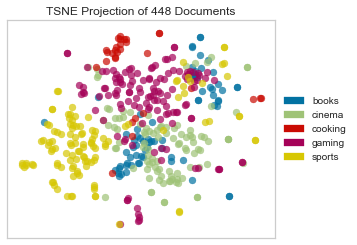

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies

# Load the data and create document vectors
corpus = load_hobbies()
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(corpus.data)
y = corpus.target

# Create the visualizer and draw the vectors
tsne = TSNEVisualizer()
tsne.fit(X, y)
tsne.show()

In [52]:
len(y)

448

In [48]:
X.shape

(448, 20140)